# **Telco Customer Churn**

# Pendahuluan

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

# Set max columns
pd.set_option('display.max_columns', None)

from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

# save pickle
from inspect import getblock
import pickle


## 1. Business Problem

### Latar Belakang
Manajemen Pemasaran sebuah perusahaan telekomunikasi menghadapi tantangan besar terkait tingkat churn pelanggan yang cukup tinggi dan mengalami kerugian sebesar $71,300. Mereka selama ini mengeluarkan biaya promosi ke seluruh pelanggan tanpa tahu siapa yang benar-benar berisiko berhenti menggunakan layanan. Strategi ini tidak efisien, karena sebagian besar promosi justru jatuh kepada pelanggan yang sebenarnya  berniat berhenti berlangganan.

Sebagai Data Scientist perusahaan, diberi tugas oleh Manajemen Pemasaran untuk mengembangkan model machine learning yang mampu memprediksi apakah seorang pelanggan akan melakukan churn atau tidak. Dengan model ini, diharapkan perusahaan:
- Dapat mengidentifikasi pelanggan yang berpotensi churn sebelum mereka benar-benar pergi.
- Dapat mengoptimalkan biaya promosi, hanya diberikan kepada pelanggan yang benar-benar membutuhkan.
- Dapat mengurangi kerugian dari kehilangan pelanggan setia.

### Rumusan Masalah/ Problem Statement
Perusahaan telekomunikasi menghadapi tantangan dalam mempertahankan pelanggan setia di tengah persaingan industri yang semakin ketat. Customer churn atau berhentinya pelanggan menggunakan layanan, dapat menyebabkan kerugian finansial yang signifikan, terutama jika pelanggan yang churn tidak terdeteksi lebih awal.

Saat ini, perusahaan tidak memiliki sistem yang mampu memprediksi kemungkinan pelanggan akan berhenti berlangganan. Akibatnya, strategi promosi dilakukan secara massal ke seluruh pelanggan, yang mengakibatkan biaya promosi yang besar namun tidak efisien.

Diperlukan sebuah sistem berbasis Machine Learning untuk membantu perusahaan dalam:
- Memprediksi lebih dini siapa saja pelanggan yang kemungkinan akan churn,
- Meminimalkan kehilangan pelanggan dengan memberikan promosi tepat sasaran hanya kepada mereka yang berisiko churn,
- Mengurangi pemborosan biaya promosi kepada pelanggan yang sebenarnya tidak akan churn.

### Metric Evaluation
- Cost FP: $100
- Cost FN: $500

False Positive (FP): Model memprediksi seorang customer akan churn → perusahaan memberi promosi senilai $100, tetapi sebenarnya customer tidak churn.
→ Biaya promosi sia-sia.

False Negative (FN): Model memprediksi customer tidak akan churn → perusahaan tidak melakukan tindakan, tetapi sebenarnya customer churn.
→ Perusahaan kehilangan customer dengan potensi kerugian $500.

Karena cost dari FN jauh lebih tinggi dibanding FP, karena itu F2-score dipilih sebagai metrik evaluasi utama, karena F2-score memberikan lebih banyak bobot ke recall.

### Tujuan/ Goals
1. Memprediksi Churn Pelanggan
Mengembangkan model Machine Learning yang dapat mengidentifikasi pelanggan yang berpotensi churn (berhenti berlangganan) berdasarkan data historis pelanggan.

2. Mengurangi Kerugian Finansial
Membantu perusahaan mengurangi biaya akibat kehilangan pelanggan (False Negative) yang memiliki dampak finansial besar ($500 per pelanggan) dengan memberikan penanganan preventif.

3. Mengoptimalkan Strategi Promosi
Mengurangi pemborosan promosi kepada pelanggan loyal (False Positive) yang sebenarnya tidak akan churn ($100 per pelanggan) dengan hanya menargetkan pelanggan yang benar-benar berisiko tidak churn.

4. Menggunakan Metode Evaluasi yang Tepat
Menggunakan metrik F2 Score sebagai acuan utama untuk mengevaluasi model, karena memberikan penekanan lebih besar pada minimisasi False Negative.

5. Memberikan Insight Fitur Penting
Mengidentifikasi fitur-fitur yang paling berkontribusi terhadap keputusan churn agar perusahaan dapat melakukan intervensi bisnis yang lebih tepat sasaran (misalnya melalui peningkatan layanan atau paket berlangganan).

## 2. Load Dataset

In [2]:
#Load Dataset
df = pd.read_csv("D:\PURWADHIKA\VS_CODE\Capstone_Modul_3\data_telco_customer_churn.csv")
df

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No
...,...,...,...,...,...,...,...,...,...,...,...
4925,No,15,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,103.45,No
4926,Yes,10,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,91.10,No
4927,No,58,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.75,No
4928,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.75,Yes


### Data Understanding

In [3]:
len(df)

4930

In [4]:
len(df.columns)

11

#### Kondisi Data Awal
-	Data awal pada file data_telco_customer_churn.csv mempunyai 4930 baris.
-	Data memiliki 11 kolom yang terdiri dari 10 kolom feature dan 1 kolom target, kolom target pada data ini adalah Churn.
-	Churn ini adalah Target variabel yang mengartikan apakah pelanggan berhenti berlangganan atau tidak.
-	Tipe datanya 9 bertipe Kategorikal dan 2 bertipe Numerikal.

#### 1. Dependents

* Definisi: Menunjukkan apakah pelanggan memiliki tanggungan (anak, pasangan, atau anggota keluarga lain).
* Tipe data: `object` (kategorikal)
* Nilai unik: `Yes`, `No`

  * `Yes` → Pelanggan memiliki tanggungan.
  * `No` → Tidak memiliki tanggungan.

---

#### 2. tenure

* Definisi: Lama waktu (dalam bulan) pelanggan telah berlangganan.
* Tipe data: `int64` (numerik)
* Nilai contoh: `16`, `9`, `18` (terdapat 73 nilai unik)

  * Angka yang lebih tinggi menunjukkan pelanggan yang telah lama berlangganan.

---

#### 3. OnlineSecurity

* Definisi: Apakah pelanggan memiliki layanan keamanan online.
* Tipe data: `object`
* Nilai unik: `Yes`, `No`, `No internet service`

  * `Yes` → Pelanggan berlangganan keamanan online.
  * `No` → Tidak berlangganan.
  * `No internet service` → Tidak memiliki layanan internet, sehingga fitur ini tidak relevan.

---

#### 4. OnlineBackup

* Definisi: Apakah pelanggan memiliki layanan backup data online.
* Tipe data: `object`
* Nilai unik: `Yes`, `No`, `No internet service`

---

#### 5. InternetService

* Definisi: Jenis layanan internet yang dimiliki pelanggan.
* Tipe data: `object`
* Nilai unik: `DSL`, `Fiber optic`, `No`

  * `DSL` → Jenis layanan internet standar.
  * `Fiber optic` → Internet berkecepatan tinggi.
  * `No` → Tidak memiliki layanan internet.

---

#### 6. DeviceProtection

* Definisi: Apakah pelanggan memiliki perlindungan perangkat.
* Tipe data: `object`
* Nilai unik: `Yes`, `No`, `No internet service`
* Makna mirip dengan kolom OnlineSecurity dan OnlineBackup.

---

#### 7. TechSupport

* Definisi: Apakah pelanggan memiliki dukungan teknis dari penyedia.
* Tipe data: `object`
* Nilai unik: `Yes`, `No`, `No internet service`

---

#### 8. Contract

* Definisi: Jenis kontrak berdasarkan durasi langganan.
* Tipe data: `object`
* Nilai unik: `Month-to-month`, `One year`, `Two year`

  * `Month-to-month` → Fleksibel, mudah berhenti.
  * `One year`, `Two year` → Terikat kontrak jangka panjang.


---

#### 9. PaperlessBilling

* Definisi: Apakah pelanggan menggunakan tagihan tanpa kertas.
* Tipe data: `object`
* Nilai unik: `Yes`, `No`

  * `Yes` → Tagihan dikirim via email/digital.
  * `No` → Masih menggunakan tagihan fisik.

---

#### 10. MonthlyCharges

* Definisi: Jumlah biaya langganan bulanan.
* Tipe data: `float64`
* Nilai unik: 1422 (nilai numerik kontinu)

  * Nilai lebih tinggi berarti pelanggan membayar lebih banyak layanan.


---

#### 11. Churn

* Definisi: Target variabel — apakah pelanggan berhenti berlangganan atau tidak.
* Tipe data: `object`
* Nilai unik: `Yes` -> 1, `No` -> 0

  * `Yes`/ 1 → Pelanggan berhenti (*churn*).
  * `No`/ 0 → Pelanggan tetap berlangganan.



In [5]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


In [6]:
df.columns

Index(['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
       'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'MonthlyCharges', 'Churn'],
      dtype='object')

In [7]:
df["MonthlyCharges"].unique()

array([ 72.9 ,  82.65,  47.85, ...,  58.45,  23.65, 108.5 ])

In [8]:
display(df["MonthlyCharges"].min(),df["MonthlyCharges"].max())

18.8

118.65

In [9]:
df["MonthlyCharges"].median()

70.35

### Data Cleaning

In [10]:
df.shape

(4930, 11)

In [11]:
listItem = []
for col in df.columns:
    unique_vals = df[col].drop_duplicates()
    sample_size = min(len(unique_vals), 3)  # antisipasi error
    listItem.append([
        col,
        df[col].dtype,
        df[col].isna().sum(),
        round((df[col].isna().sum()/len(df[col])) * 100, 2),
        df[col].nunique(),
        list(unique_vals.sample(sample_size).values)
    ])

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                      data=listItem)
dfDesc


,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Dependents,object,0,0.0,2,"[Yes, No]"
1,tenure,int64,0,0.0,73,"[46, 12, 24]"
2,OnlineSecurity,object,0,0.0,3,"[No internet service, No, Yes]"
3,OnlineBackup,object,0,0.0,3,"[Yes, No, No internet service]"
4,InternetService,object,0,0.0,3,"[No, Fiber optic, DSL]"
5,DeviceProtection,object,0,0.0,3,"[No, Yes, No internet service]"
6,TechSupport,object,0,0.0,3,"[No, No internet service, Yes]"
7,Contract,object,0,0.0,3,"[Two year, Month-to-month, One year]"
8,PaperlessBilling,object,0,0.0,2,"[Yes, No]"
9,MonthlyCharges,float64,0,0.0,1422,"[50.35, 84.6, 45.2]"


Melalui keterangan pada df_info dan df_shape, jumlah data setiap kolom adalah 4930.<br>
Sehingga dapat disimpulkan **tidak terdapat missing values** didalam dataset.<br>
Selanjutnya kita akan mencari apakah didalam dataset terdapat nilai duplikat atau tidak.

melihat duplicate

In [12]:
df.duplicated().sum()

77

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df.isna().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

In [15]:
df.shape

(4853, 11)

Numerik

In [16]:
df.describe()

,tenure,MonthlyCharges
count,4853.000000,4853.000000
mean,32.679992,65.321543
std,24.395554,29.783655
min,0.000000,18.800000
25%,9.000000,40.050000
50%,29.000000,70.600000
75%,56.000000,90.050000
max,72.000000,118.650000


Kategorikal

In [17]:
df.describe(include=['O'])

,Dependents,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,Churn
count,4853,4853,4853,4853,4853,4853,4853,4853,4853
unique,2,3,3,3,3,3,3,2,2
top,No,No,No,Fiber optic,No,No,Month-to-month,Yes,No
freq,3380,2420,2148,2154,2162,2442,2665,2925,3565


In [18]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

Merubah value kolom Churn:
- Yes - > 1 
- No ->0

# Analisis Data

## 3. EDA

In [19]:
persentase_data_churn = pd.DataFrame(df['Churn'].value_counts()/len (df)).reset_index().rename(columns={'index':'Churn','Churn':'%'})
jumlah_data_churn = pd.DataFrame(df['Churn'].value_counts()).reset_index().rename(columns={'index':'Churn','Churn':'Jumlah'})
display(persentase_data_churn,jumlah_data_churn)

,%,count
0,0,0.734597
1,1,0.265403


,Jumlah,count
0,0,3565
1,1,1288


In [20]:
df.columns

Index(['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
       'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'MonthlyCharges', 'Churn'],
      dtype='object')

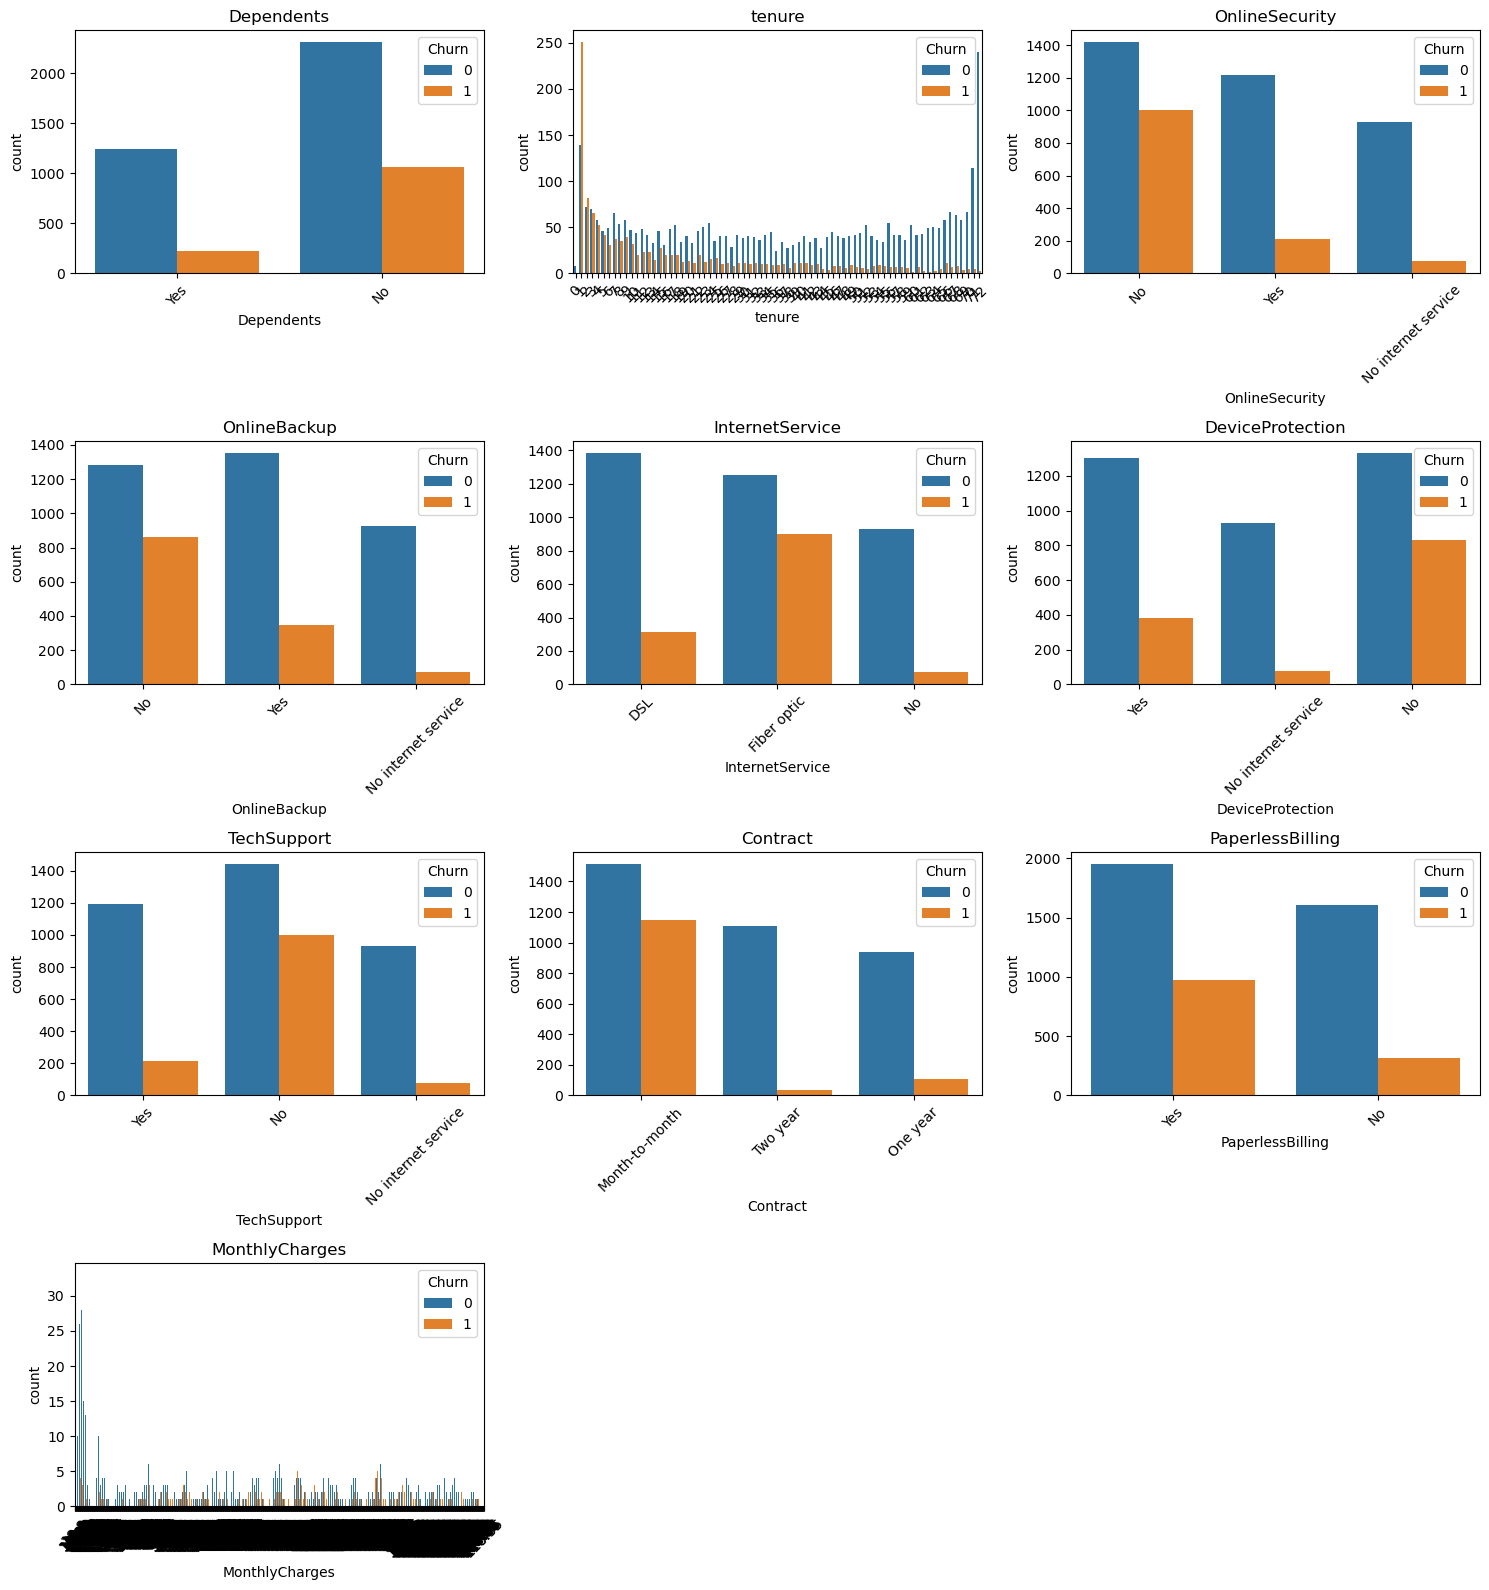

In [21]:
features = ['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
       'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'MonthlyCharges']

n = len(features)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(5 * cols, 4 * rows))
for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    sns.countplot(x=feature, hue='Churn', data=df)
    plt.title(feature)
    plt.xlabel(feature)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [22]:

for feature in features:
    pivot = pd.crosstab(df[feature], df['Churn'])
    print("p-value:", chi2_contingency(pivot)[1], f"\t Churn vs {feature}")
    display(pivot)


p-value: 5.671674035170086e-32 	 Churn vs Dependents


Churn,0,1
Dependents,,
No,2316,1064
Yes,1249,224


p-value: 5.1959381239234065e-118 	 Churn vs tenure


Churn,0,1
tenure,,
0,8,0
1,139,251
2,72,82
3,70,65
4,58,52
...,...,...
68,63,8
69,58,4
70,67,5


p-value: 2.094002266781991e-122 	 Churn vs OnlineSecurity


Churn,0,1
OnlineSecurity,,
No,1419,1001
No internet service,928,75
Yes,1218,212


p-value: 5.108335989696018e-93 	 Churn vs OnlineBackup


Churn,0,1
OnlineBackup,,
No,1284,864
No internet service,928,75
Yes,1353,349


p-value: 1.8831975298397085e-110 	 Churn vs InternetService


Churn,0,1
InternetService,,
DSL,1385,311
Fiber optic,1252,902
No,928,75


p-value: 6.357782164269978e-78 	 Churn vs DeviceProtection


Churn,0,1
DeviceProtection,,
No,1332,830
No internet service,928,75
Yes,1305,383


p-value: 1.1995786432172319e-117 	 Churn vs TechSupport


Churn,0,1
TechSupport,,
No,1443,999
No internet service,928,75
Yes,1194,214


p-value: 1.1199110454640424e-185 	 Churn vs Contract


Churn,0,1
Contract,,
Month-to-month,1515,1150
One year,939,106
Two year,1111,32


p-value: 4.3923232357695654e-38 	 Churn vs PaperlessBilling


Churn,0,1
PaperlessBilling,,
No,1611,317
Yes,1954,971


p-value: 5.709614089045677e-11 	 Churn vs MonthlyCharges


Churn,0,1
MonthlyCharges,,
18.80,3,0
18.85,3,1
18.90,2,0
18.95,5,1
19.00,4,1
...,...,...
117.80,0,1
118.20,1,0
118.35,0,1


Dilihat dari pvalue Churn (target) berkaitan dengan feature 'Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup', 'InternetService', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'MonthlyCharges'.

**numerical features**

In [23]:
df.describe()

,tenure,MonthlyCharges,Churn
count,4853.000000,4853.000000,4853.000000
mean,32.679992,65.321543,0.265403
std,24.395554,29.783655,0.441593
min,0.000000,18.800000,0.000000
25%,9.000000,40.050000,0.000000
50%,29.000000,70.600000,0.000000
75%,56.000000,90.050000,1.000000
max,72.000000,118.650000,1.000000


In [24]:
num_features = ['tenure', 'MonthlyCharges']

for feat in num_features:
    # Ambil dua kelompok berdasarkan Churn
    churn_no = df[df['Churn'] == 0][feat]
    churn_yes = df[df['Churn'] == 1][feat]

    # Uji Mann-Whitney
    stat, pvalue = mannwhitneyu(churn_no, churn_yes)

    # Interpretasi hasil
    hasil = 'terkait' if pvalue < 0.05 else 'tidak terkait'
    print(f"{feat}: p-value = {pvalue:.4f} → {hasil} dengan churn")


tenure: p-value = 0.0000 → terkait dengan churn
MonthlyCharges: p-value = 0.0000 → terkait dengan churn


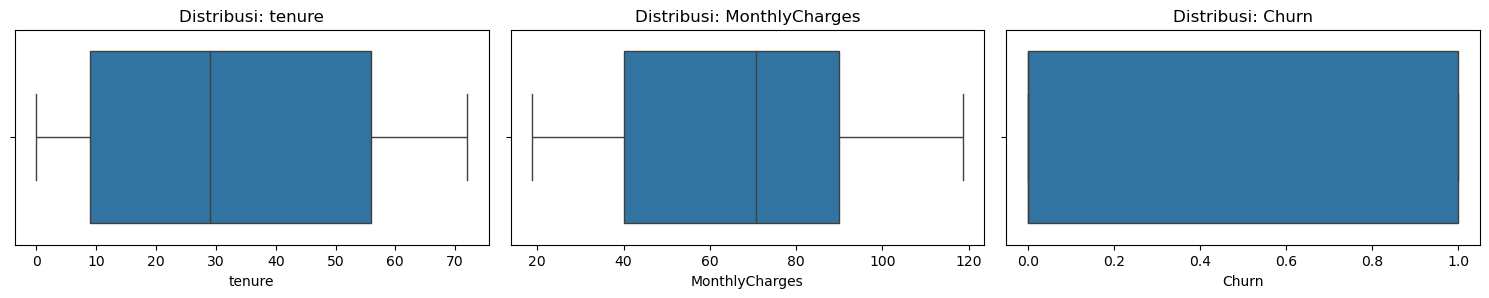

In [25]:
numerikal_col=df.describe().columns

plt.figure(figsize=(15, 30))
for i, data in enumerate(numerikal_col):
    plt.subplot(11, 3, i+1)
    sns.boxplot(x=df[data])
    plt.title(f'Distribusi: {data}')
    plt.xlabel(data)


plt.tight_layout()
plt.show()

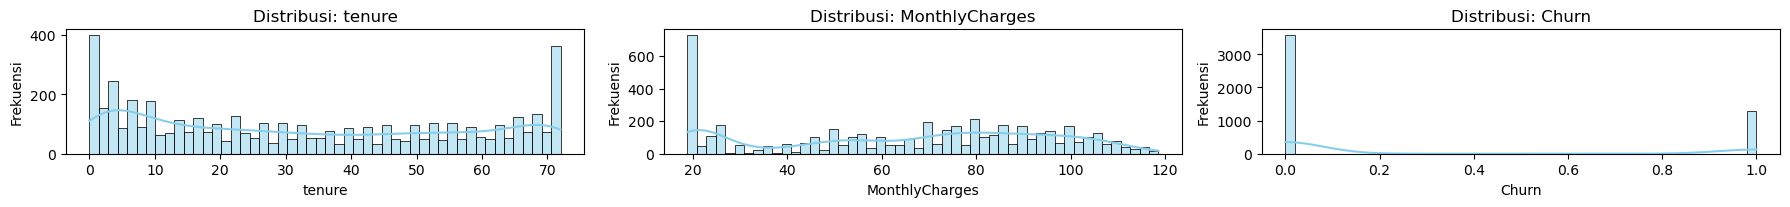

In [26]:
numerikal_col=df.describe().columns

plt.figure(figsize=(18, 20))
for i, data in enumerate(numerikal_col):
    plt.subplot(11, 3, i+1)
    sns.histplot(df[data], kde=True, bins=50, color='skyblue')
    plt.title(f'Distribusi: {data}')
    plt.xlabel(data)
    plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

- Pada kolom semua numerikal tidak terdapat outlier.
- Terlihat pada seluruh kolom numerikal kontinu tidak terditribusi normal, dengan demikan akan digunakan scaling pada modeling nanti

In [27]:
df.shape

(4853, 11)

Kategorikal feature

In [28]:
# Ambil semua kolom kategorikal
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns

for feature in categorical_features:
    pivot = pd.crosstab(df[feature], df['Churn'])
    chi2, p, dof, ex = chi2_contingency(pivot)
    print(f"Churn vs {feature} \t p-value: {p:.4f}")
    display(pivot)


Churn vs Dependents 	 p-value: 0.0000


Churn,0,1
Dependents,,
No,2316,1064
Yes,1249,224


Churn vs OnlineSecurity 	 p-value: 0.0000


Churn,0,1
OnlineSecurity,,
No,1419,1001
No internet service,928,75
Yes,1218,212


Churn vs OnlineBackup 	 p-value: 0.0000


Churn,0,1
OnlineBackup,,
No,1284,864
No internet service,928,75
Yes,1353,349


Churn vs InternetService 	 p-value: 0.0000


Churn,0,1
InternetService,,
DSL,1385,311
Fiber optic,1252,902
No,928,75


Churn vs DeviceProtection 	 p-value: 0.0000


Churn,0,1
DeviceProtection,,
No,1332,830
No internet service,928,75
Yes,1305,383


Churn vs TechSupport 	 p-value: 0.0000


Churn,0,1
TechSupport,,
No,1443,999
No internet service,928,75
Yes,1194,214


Churn vs Contract 	 p-value: 0.0000


Churn,0,1
Contract,,
Month-to-month,1515,1150
One year,939,106
Two year,1111,32


Churn vs PaperlessBilling 	 p-value: 0.0000


Churn,0,1
PaperlessBilling,,
No,1611,317
Yes,1954,971


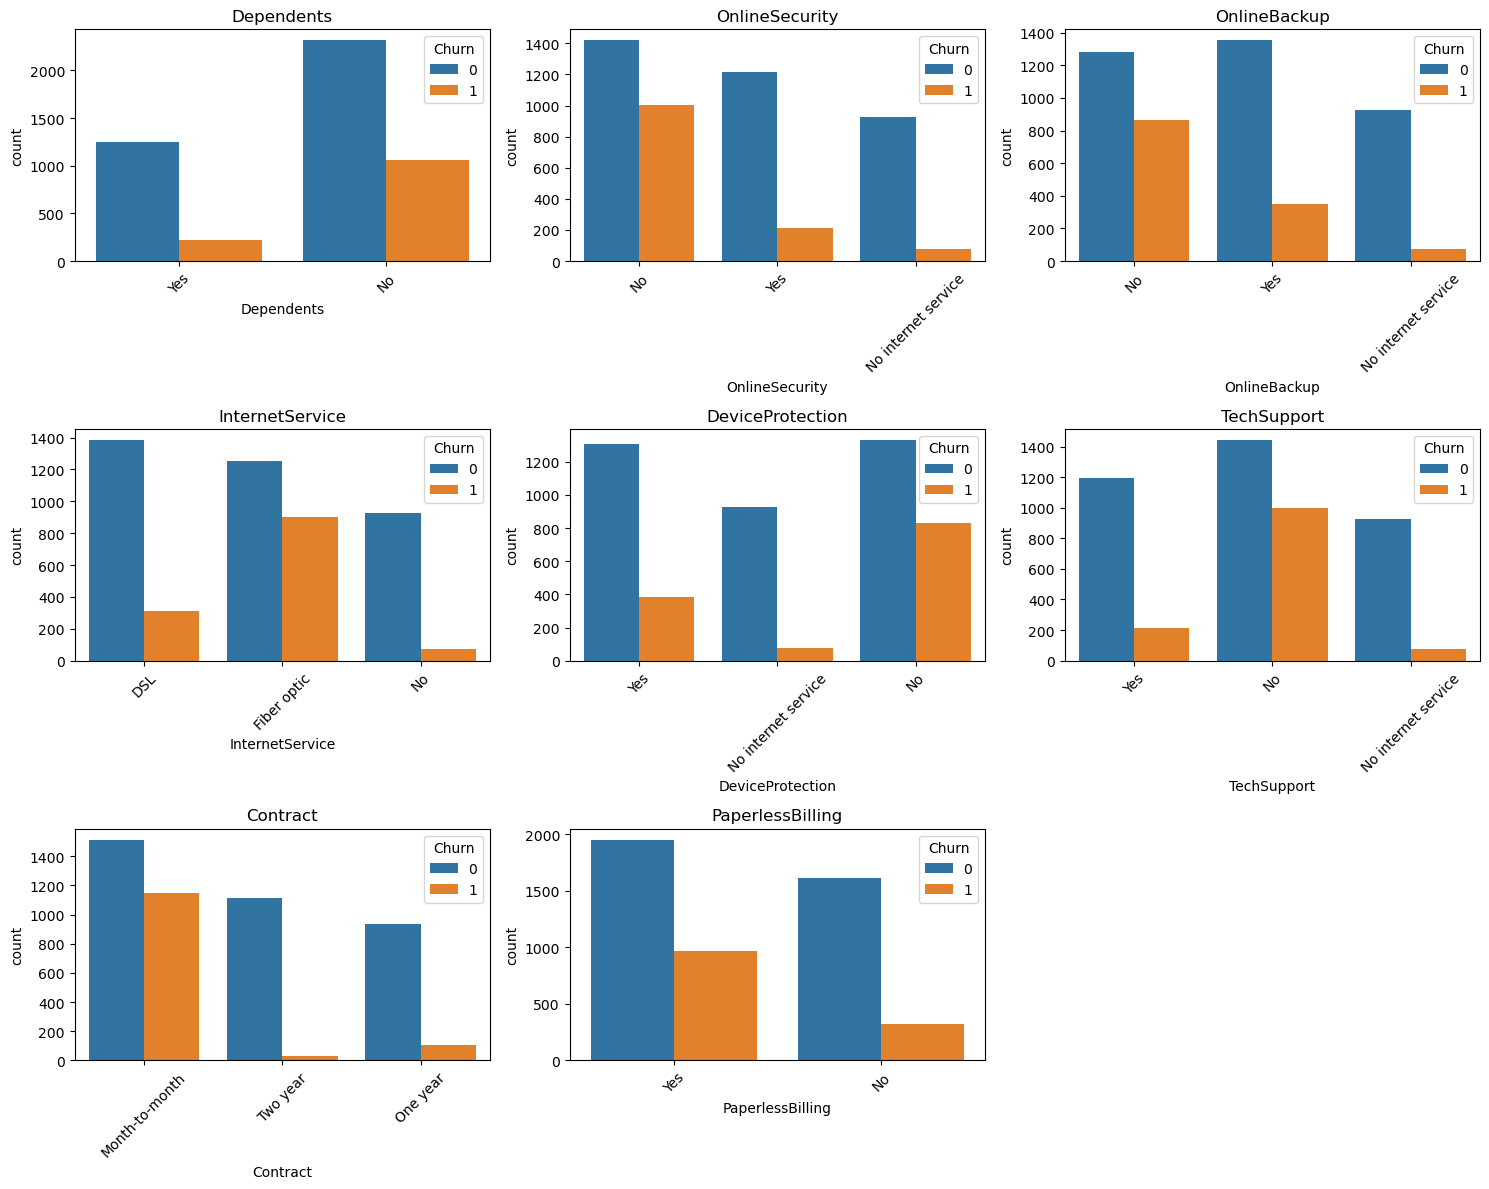

In [29]:
features_kategorikal = ['Dependents', 'OnlineSecurity', 'OnlineBackup',
       'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling']

n = len(features_kategorikal)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(5 * cols, 4 * rows))
for i, feature in enumerate(features_kategorikal):
    plt.subplot(rows, cols, i + 1)
    sns.countplot(x=feature, hue='Churn', data=df)
    plt.title(feature)
    plt.xlabel(feature)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1. Dependents : Target promosi churn bisa difokuskan ke pelanggan tanpa tanggungan.
2. OnlineSecurity: Menawarkan keamanan online bisa membantu mengurangi churn.
3. OnlineBackup: Layanan backup dapat ditawarkan sebagai inisiatif retensi.
4. InternetService: Layanan fiber optic mungkin memiliki masalah yang memicu churn (harga/layanan).
5. DeviceProtection: Edukasi nilai layanan tambahan seperti device protection bisa mengurangi churn.
6. TechSupport: Memberikan akses mudah ke dukungan teknis bisa meningkatkan retensi.
7. Contract: Mempromosikan kontrak jangka panjang dapat secara signifikan mengurangi churn.
8. PaperlessBilling: Buat program loyalitas untuk pelanggan paperless agar tetap bertahan.

# Machine Learning Modeling

## 4. Define X and y

In [32]:
X = df.drop(['Churn'], axis=1)
X

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60
...,...,...,...,...,...,...,...,...,...,...
4925,No,15,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,103.45
4926,Yes,10,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,91.10
4927,No,58,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.75
4928,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.75


In [33]:
y = df['Churn']
y

0       1
1       0
2       1
3       0
4       0
       ..
4925    0
4926    0
4927    0
4928    1
4929    0
Name: Churn, Length: 4853, dtype: int64

In [30]:
X.columns

Index(['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
       'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'MonthlyCharges'],
      dtype='object')

Melakukan pengelompokan data dimana kolom Churn adalah target (y) dan 10 kolom lainnya adalah feature (X)

## 5. Data Splitting

In [31]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    stratify=y,
    test_size=0.2,
    random_state=0
)

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4853 entries, 0 to 4929
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4853 non-null   object 
 1   tenure            4853 non-null   int64  
 2   OnlineSecurity    4853 non-null   object 
 3   OnlineBackup      4853 non-null   object 
 4   InternetService   4853 non-null   object 
 5   DeviceProtection  4853 non-null   object 
 6   TechSupport       4853 non-null   object 
 7   Contract          4853 non-null   object 
 8   PaperlessBilling  4853 non-null   object 
 9   MonthlyCharges    4853 non-null   float64
dtypes: float64(1), int64(1), object(8)
memory usage: 417.1+ KB


## 6. Data Preprocessing

Encoding : OneHot :`'Dependents', 'OnlineSecurity' 'OnlineBackup', 'InternetService' 'DeviceProtection','TechSupport', 'Contract','PaperlessBilling'`

Scaling : Robust :`'tenure', 'MonthlyCharges'`

In [33]:
X.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60


In [34]:
transformer = ColumnTransformer([
    ('scaling', RobustScaler(), ['tenure', 'MonthlyCharges']),
    ('onehot', OneHotEncoder(drop='first'), ['Dependents', 'OnlineSecurity','OnlineBackup',
                                             'InternetService','DeviceProtection','TechSupport',
                                             'Contract','PaperlessBilling'])
], remainder='passthrough')

- OneHot Encoding digunakan untuk mengubah fitur kategorikal (seperti Contract, InternetService, PaymentMethod, dll) menjadi bentuk numerikal agar dapat digunakan dalam algoritma Machine Learning, yang hanya dapat memproses data numerik.
- RobustScaler digunakan untuk mengurangi pengaruh outlier saat melakukan normalisasi fitur numerik, seperti MonthlyCharges dan TotalCharges.

### resampling

In [ ]:
smote = SMOTE(random_state=0)
nearmiss = NearMiss()
rus = RandomUnderSampler(random_state=0)
ros = RandomOverSampler(random_state=0)

- Mengatasi masalah ketidakseimbangan kelas (class imbalance), yaitu saat jumlah pelanggan yang churn jauh lebih sedikit dibanding yang tidak churn.

### Model Benchmark

In [38]:
logreg = LogisticRegression(random_state=0, class_weight='balanced')
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0, class_weight='balanced') 
rf = RandomForestClassifier(random_state=0, class_weight='balanced') 
ada = AdaBoostClassifier(tree, random_state=0)
gbc = GradientBoostingClassifier(random_state=0)
xgbc = XGBClassifier(random_state=0, verbosity=0, class_weight='balanced')

- model awal (baseline) yang digunakan untuk mengukur performa sebelum dilakukan optimasi seperti:

In [39]:
# Define imbalanced treatment method
models = [logreg, knn, tree, rf, ada, gbc, xgbc]
score = []
nilai_mean = []
nilai_std = []

# F2 score (Karena cost dari FN (diprediksi tidak churn, padahal aslinya churn) lebih tinggi dari pada FP (diprediksi churn, padahal aslinya tidak churn))
f2_score = make_scorer(fbeta_score, beta=2)

for i in models:

    pipe_model = Pipeline([
        ('transformer', transformer),
        ('resampler', ros),
        ('model', i)
    ])

    model_cv = cross_val_score(
        estimator = pipe_model, 
        X= X_train, 
        y= y_train, 
        cv=5, 
        scoring=f2_score, 
        error_score='raise'
        )

    # print(model_cv, i)

    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [40]:
df_cv = pd.DataFrame({
    'model':['logreg', 'knn', 'tree', 'rf',' ada', 'gbc', 'xgbc'],
    'mean':nilai_mean,
    'std':nilai_std
})

df_cv.sort_values('mean',ascending=False)

,model,mean,std
5,gbc,0.709358,0.012377
0,logreg,0.705890,0.015714
1,knn,0.622161,0.010437
6,xgbc,0.612422,0.009265
3,rf,0.552271,0.009602
4,ada,0.518747,0.016346
2,tree,0.496030,0.033259


Model Logistik Regresi dan GradientBoost dipilih menjadi 2 model paling optimal karena memiliki nilai rata-rata paling tinggi.

## 7. Hyperparameter Tuning

### Logistic Regression

In [43]:
# Hyperparameter space logreg
hyperparam_space_logreg = {
    'resampler':[smote, rus, ros, None],
    'model__penalty' : ['l1','l2'],
    'model__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'model__C' : np.logspace(-3,3,7)
}

# Benchmark model 1
logreg = LogisticRegression(random_state=0, class_weight='balanced')

# Create the algorithm chains
estimator_logreg = Pipeline([
    ('transformer', transformer),
    ('resampler', rus), 
    ('model', logreg)
    ])

# Hyperparameter tuning
random_logreg = RandomizedSearchCV(
    estimator_logreg, 
    param_distributions = hyperparam_space_logreg, 
    cv = 5, 
    scoring = f2_score, 
    n_jobs = -1, 
    random_state=0,
    n_iter=1000
)

In [44]:
random_logreg.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               RobustScaler(),
                                                                               ['tenure',
                                                                                'MonthlyCharges']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Dependents',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'InternetService',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'Contract',
                                                                                'PaperlessBilling'])])),
                                             ('re...
                   param_distributions={'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'model__penalty': ['l1', 'l2'],
                                        'model__solver': ['newton-cg', 'lbfgs',
                                                          'liblinear', 'sag',
                                                          'saga'],
                                        'resampler': [SMOTE(random_state=42),
                                                      RandomUnderSampler(random_state=42),
                                                      RandomOverSampler(random_state=42),
                                                      None]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [45]:
pd.DataFrame(random_logreg.cv_results_).sort_values(by='rank_test_score').head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_resampler,param_model__solver,param_model__penalty,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
50,0.045407,0.006371,0.018106,0.001712,RandomOverSampler(random_state=42),liblinear,l1,0.010,{'resampler': RandomOverSampler(random_state=4...,0.700256,0.712490,0.727502,0.740271,0.739167,0.723937,0.015513,1
48,0.055473,0.003111,0.018086,0.002559,SMOTE(random_state=42),liblinear,l1,0.010,"{'resampler': SMOTE(random_state=42), 'model__...",0.684755,0.701681,0.734797,0.744048,0.723459,0.717748,0.021733,2
89,0.036091,0.003482,0.017332,0.003036,RandomUnderSampler(random_state=42),liblinear,l1,0.100,{'resampler': RandomUnderSampler(random_state=...,0.695652,0.724763,0.703606,0.722318,0.734144,0.716097,0.014237,3
97,0.055335,0.004695,0.017167,0.000885,RandomUnderSampler(random_state=42),saga,l1,0.100,{'resampler': RandomUnderSampler(random_state=...,0.695652,0.730145,0.702371,0.722318,0.729800,0.716057,0.014354,4
35,0.048995,0.002112,0.019735,0.003253,None,sag,l2,0.001,"{'resampler': None, 'model__solver': 'sag', 'm...",0.709402,0.759494,0.687716,0.709372,0.713066,0.715810,0.023612,5


In [46]:
print('Logreg')
print('Best_score:', random_logreg.best_score_)
print('Best_params:', random_logreg.best_params_)

Logreg
Best_score: 0.7239371836742807
Best_params: {'resampler': RandomOverSampler(random_state=42), 'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 0.01}


### GraientBoost

In [47]:
max_depth = list(np.arange(1,10))               # kedalaman pohon
learning_rate = list(np.arange(1,100)/100)      # learning rate
n_estimators = list(np.arange(50,500))          # jumlah pohon
subsample = list(np.arange(2,10)/10)            # jumlah baris train set tiap pohon (% dari total baris train set)
max_features = list(np.arange(1,10))            # jumlah feature yang digunakan untuk pertimbangan splitting (% dari total kolom train set)

# Hyperparameter space GBC
hyperparam_space_gbc = {
    'resampler':[smote, rus, ros, None],
    'model__max_depth':max_depth , 
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__max_features':max_features
}

# Benchmark model 2
gbc = GradientBoostingClassifier(random_state=0)

# Create the algorithm chains
estimator_gbc = Pipeline([
    ('transformer', transformer),
    ('resampler', rus), 
    ('model', gbc)
    ])

# Hyperparameter tuning
random_gbc = RandomizedSearchCV(
    estimator_gbc, 
    param_distributions = hyperparam_space_gbc, 
    cv = 5, 
    scoring = f2_score, 
    n_jobs = -1, 
    random_state=0,
    n_iter=1000
)

In [48]:
random_gbc.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               RobustScaler(),
                                                                               ['tenure',
                                                                                'MonthlyCharges']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Dependents',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'InternetService',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'Contract',
                                                                                'PaperlessBilling'])])),
                                             ('re...
                                        'model__n_estimators': [50, 51, 52, 53,
                                                                54, 55, 56, 57,
                                                                58, 59, 60, 61,
                                                                62, 63, 64, 65,
                                                                66, 67, 68, 69,
                                                                70, 71, 72, 73,
                                                                74, 75, 76, 77,
                                                                78, 79, ...],
                                        'model__subsample': [0.2, 0.3, 0.4, 0.5,
                                                             0.6, 0.7, 0.8,
                                                             0.9],
                                        'resampler': [SMOTE(random_state=42),
                                                      RandomUnderSampler(random_state=42),
                                                      RandomOverSampler(random_state=42),
                                                      None]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [49]:
pd.DataFrame(random_gbc.cv_results_).sort_values(by='rank_test_score').head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_resampler,param_model__subsample,param_model__n_estimators,param_model__max_features,param_model__max_depth,param_model__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
303,0.451714,0.037558,0.020541,0.005604,RandomUnderSampler(random_state=42),0.3,234,5,1,0.20,{'resampler': RandomUnderSampler(random_state=...,0.713058,0.743243,0.746978,0.729800,0.716146,0.729845,0.013729,1
9,0.289363,0.012392,0.021643,0.008466,SMOTE(random_state=42),0.3,55,9,3,0.01,"{'resampler': SMOTE(random_state=42), 'model__...",0.706288,0.737152,0.711850,0.752551,0.739796,0.729527,0.017585,2
149,0.319192,0.023876,0.019333,0.001603,RandomOverSampler(random_state=42),0.6,93,3,1,0.34,{'resampler': RandomOverSampler(random_state=4...,0.699392,0.761986,0.707465,0.736063,0.741544,0.729290,0.022958,3
381,0.892082,0.075901,0.021300,0.003277,SMOTE(random_state=42),0.2,279,8,2,0.01,"{'resampler': SMOTE(random_state=42), 'model__...",0.704348,0.741852,0.706852,0.746528,0.745047,0.728925,0.019122,4
400,0.558902,0.047394,0.018541,0.001616,RandomOverSampler(random_state=42),0.7,164,5,1,0.12,{'resampler': RandomOverSampler(random_state=4...,0.698179,0.756664,0.705575,0.732345,0.741710,0.726895,0.021975,5


In [50]:
print('GBC')
print('Best_score:', random_gbc.best_score_)
print('Best_params:', random_gbc.best_params_)

GBC
Best_score: 0.7298450434156383
Best_params: {'resampler': RandomUnderSampler(random_state=42), 'model__subsample': 0.3, 'model__n_estimators': 234, 'model__max_features': 5, 'model__max_depth': 1, 'model__learning_rate': 0.2}


f2 score di train set:

    - benchmark model Logreg: 0.705
    - hyperparameter Logreg: 0.723


    - benchmark model Gradient Boost: 0.709
    - hyperparameter tuning Gradient Boost: 0.729

## 8. Performance in Test Set

### Before Hyperparameter Tuning

In [51]:
models = [
    LogisticRegression(random_state=42, class_weight='balanced'),
    GradientBoostingClassifier(random_state=42)
]
model_names = ['LogisticRegression', 'GradientBoostingClassifier']

# Dictionary untuk menyimpan skor
f2_scores = {}

# Looping
for i, model in enumerate(models):
    print(f"Running model: {model_names[i]}")

    model_pipe = Pipeline([
        ('transformer', transformer),
        ('balancing', smote),
        ('model', model)
    ])
    
    # fitting
    model_pipe.fit(X_train, y_train)
    
    # predict
    y_pred = model_pipe.predict(X_test)
    
    # F2 Score
    f2 = fbeta_score(y_test, y_pred, beta=2)
    f2_scores[model_names[i]] = f2
    print(f"F2 Score: {f2:.4f}\n")
    
f2_scores


Running model: LogisticRegression
F2 Score: 0.7203

Running model: GradientBoostingClassifier
F2 Score: 0.7066



{'LogisticRegression': 0.7203092059030218,
 'GradientBoostingClassifier': 0.7066381156316917}

### After Hyperparameter Tuning

In [52]:
best_models = [
    random_logreg.best_estimator_,
    random_gbc.best_estimator_
]
model_names = ['LogisticRegression (Tuned)', 'GradientBoostingClassifier (Tuned)']

# Dictionary untuk menyimpan F2 Score tuning
f2_scores_tuned = {}

# Looping evaluasi
for i, model in enumerate(best_models):
    print(f"Evaluating: {model_names[i]}")

    # Fitting
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # F2 Score
    f2 = fbeta_score(y_test, y_pred, beta=2)
    f2_scores_tuned[model_names[i]] = f2
    print(f"F2 Score: {f2:.4f}\n")

f2_scores_tuned

Evaluating: LogisticRegression (Tuned)
F2 Score: 0.7182

Evaluating: GradientBoostingClassifier (Tuned)
F2 Score: 0.7554



{'LogisticRegression (Tuned)': 0.718213058419244,
 'GradientBoostingClassifier (Tuned)': 0.7553707553707554}

f2 score di test set:

    - Before tuning model Logistic Regression: 0.72
    - After tuning model Logistic Regression: 0.718

    - Before tuning model GradientBoos: 0.71
    - After tuning model GradientBoos: 0.755

- Logistic Regression mengalami penurunan performa setelah tuning, sehingga tidak menjadi pilihan utama.
- Model terbaik berdasarkan F2-score adalah: Gradient Boosting setelah tuning.
    - Mencapai F2-score tertinggi sebesar 0.755, menunjukkan kinerja terbaik dalam mengidentifikasi pelanggan yang churn dengan mengutamakan recall.
    - Performa meningkat setelah tuning, terutama pada recall untuk kelas 1 (churn) dari 0.718 ke 0.755, yang selaras dengan tujuan bisnis.

## 9. Best Model Performance in Test Set

### Before Hyperparameter Tuning

In [53]:
model = GradientBoostingClassifier(random_state=0)

model_pipe = Pipeline([
    ('transformer', transformer),
    ('balancing', smote),
    ('model', model)
])

# fitting
model_pipe.fit(X_train, y_train)

# predict
y_pred = model_pipe.predict(X_test)

# recall score
f2score_gbc_benchmark = fbeta_score(y_test, y_pred, beta=2)
f2score_gbc_benchmark

0.7066381156316917

### After Hyperparameter Tuning

In [54]:
# best model
gbc_tuning = random_gbc.best_estimator_

# fitting
gbc_tuning.fit(X_train, y_train)

# predict
y_pred_gbc_tuning = gbc_tuning.predict(X_test)

# recall score
f2score_gbc_tuning = fbeta_score(y_test, y_pred_gbc_tuning, beta=2)
f2score_gbc_tuning

0.7553707553707554

In [ ]:
print(f2score_gbc_benchmark, 'GraientBoost Benchmark')
print(f2score_gbc_tuning, 'GraientBoost Tuning')

0.7188841201716738 GraientBoost Benchmark
0.7363253856942497 GraientBoost Tuning


f2 score di test set:

    - Before tuning model GradientBoos: 0.71
    - After tuning model GradientBoos: 0.755


Model Gradient Boosting setelah tuning adalah pilihan yang lebih optimal, karena memberikan kinerja lebih baik dalam mendeteksi pelanggan churn, sesuai dengan tujuan utama yang mengedepankan recall (ditangkap oleh F2-score).

## 10. Classification Report

In [55]:
print('GraientBoost Before Tuning')
print(classification_report(y_test, y_pred))

GraientBoost Before Tuning
              precision    recall  f1-score   support

           0       0.90      0.76      0.82       713
           1       0.54      0.77      0.63       258

    accuracy                           0.76       971
   macro avg       0.72      0.76      0.73       971
weighted avg       0.80      0.76      0.77       971



Gradient Boosting Classifier - Before Tuning

- Model menunjukkan performa baik dalam mendeteksi pelanggan churn (kelas 1) dengan recall sebesar 0.77, artinya 77% dari pelanggan yang benar-benar churn berhasil teridentifikasi.

- Precision kelas 1 masih rendah (0.54), yang mengindikasikan banyak prediksi churn yang keliru (false positive), yaitu pelanggan yang sebenarnya tidak churn tetapi diprediksi akan churn.

- F1-score kelas 1 sebesar 0.63 mencerminkan adanya ketidakseimbangan antara precision dan recall. Hal ini penting untuk diperhatikan karena dalam kasus churn prediction, keseimbangan keduanya sangat krusial.

- Model secara keseluruhan memiliki akurasi 76%, dengan macro average F1-score 0.73 dan weighted average F1-score 0.77, yang menunjukkan performa cukup stabil pada keseluruhan data, meskipun masih bias terhadap kelas mayoritas.

- Berdasarkan hasil ini, model masih perlu ditingkatkan, terutama dari sisi precision untuk kelas churn. Oleh karena itu, disarankan untuk melakukan hyperparameter tuning dan penanganan imbalance agar model lebih akurat dan seimbang dalam prediksi churn.

In [57]:
print('GraientBoost After Tuning')
print(classification_report(y_test, y_pred_gbc_tuning))

GraientBoost After Tuning
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       713
           1       0.53      0.84      0.65       258

    accuracy                           0.76       971
   macro avg       0.73      0.79      0.73       971
weighted avg       0.82      0.76      0.77       971



Gradient Boosting Classifier - After Tuning

- Setelah tuning, recall untuk kelas churn (kelas 1) meningkat menjadi 0.84, menunjukkan bahwa model semakin baik dalam menangkap pelanggan yang benar-benar akan churn (84% berhasil teridentifikasi).

- Precision kelas 1 tetap rendah (0.53), sehingga masih terdapat cukup banyak false positive. Ini menandakan bahwa meskipun lebih banyak churn terdeteksi, masih banyak pelanggan non-churn yang salah diklasifikasikan.

- F1-score untuk kelas 1 naik tipis ke 0.65 dari sebelumnya 0.63, menunjukkan peningkatan keseimbangan antara precision dan recall, meskipun peningkatannya belum signifikan.

- Akurasi keseluruhan tetap di angka 76%, namun macro recall meningkat dari 0.76 menjadi 0.79, menandakan bahwa model lebih adil dalam mempelajari kedua kelas.

- Weighted average f1-score tetap 0.77, menunjukkan stabilitas model terhadap distribusi kelas.

- Secara umum, tuning berhasil meningkatkan kemampuan model dalam mengenali churn (recall naik), namun masih perlu perbaikan lebih lanjut pada precision untuk mengurangi false positive.

## 11. Confusion Matrix

Text(0.5, 1.0, 'GraientBoost before tuning')

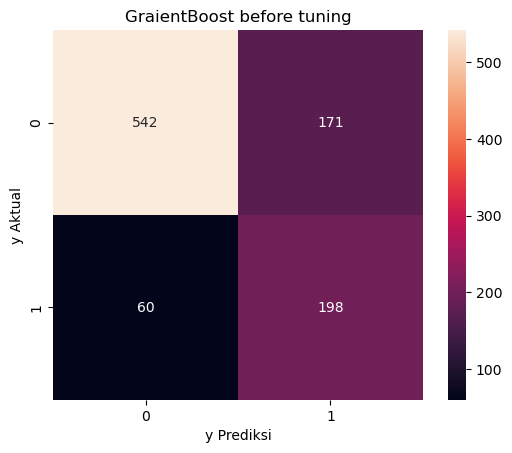

In [58]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('GraientBoost before tuning')

Sebelum Tuning – GradientBoost

- True Negative (TN): 542 pelanggan tidak churn, dan berhasil diprediksi dengan benar.
- True Positive (TP): 198 pelanggan churn berhasil dikenali oleh model.
- False Positive (FP): 171 pelanggan sebenarnya tidak churn, tapi diprediksi akan churn.
- False Negative (FN): 60 pelanggan yang seharusnya churn justru tidak terdeteksi oleh model.

Model cukup baik mengenali pelanggan churn, namun masih terdapat jumlah FN yang signifikan (60) — artinya pelanggan berisiko churn bisa luput dari perhatian jika tidak ditindaklanjuti.

Jumlah FP juga tinggi (171), bisa berdampak pada upaya retensi yang sia-sia pada pelanggan yang sebenarnya tidak berniat churn.

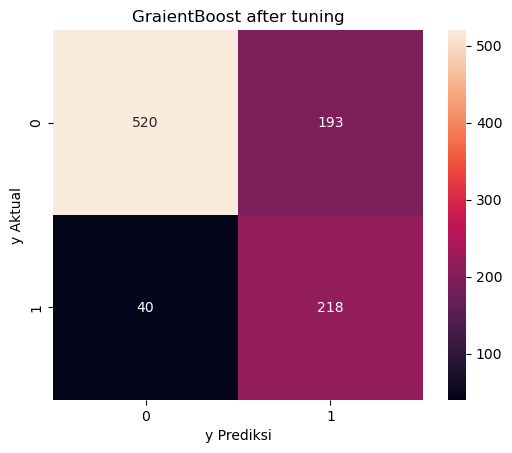

In [59]:
sns.heatmap(confusion_matrix(y_test, y_pred_gbc_tuning), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('GraientBoost after tuning');

Sesudah Tuning – GradientBoost
- True Negative (TN): 520 pelanggan tidak churn diprediksi dengan benar.
- True Positive (TP): 218 pelanggan churn berhasil diprediksi dengan tepat.
- False Positive (FP): 193 pelanggan sebenarnya tidak churn namun diprediksi akan churn.
- False Negative (FN): 40 pelanggan yang seharusnya churn tidak terdeteksi.


Setelah tuning, model lebih baik dalam mendeteksi pelanggan yang benar-benar churn (TP naik, FN turun).

Namun, ada kenaikan FP, artinya lebih banyak pelanggan tidak churn yang salah diprediksi akan churn — ini berpotensi menyebabkan upaya retensi yang tidak efisien.

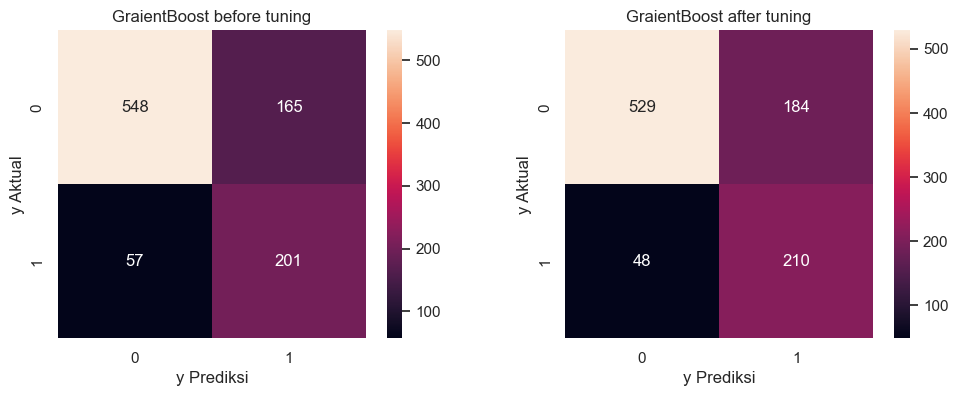

In [ ]:
plt.figure(figsize=(12,4))

# Model GraientBoost before tuning
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('GraientBoost before tuning')

# Model GraientBoost after tuning
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_gbc_tuning), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('GraientBoost after tuning');

In [ ]:
y_test.value_counts()

Churn
0    713
1    258
Name: count, dtype: int64

Tujuan dari proyek ini adalah untuk memprediksi apakah seorang pelanggan akan melakukan churn (berhenti berlangganan) dari layanan Telco, sehingga perusahaan dapat melakukan tindakan pencegahan yang tepat sasaran dan efisien dari sisi biaya.

- False Positive (FP): Model memprediksi pelanggan akan churn → Perusahaan memberikan promosi/inisiatif retensi ($100 per pelanggan), namun sebenarnya pelanggan tidak akan churn.
- False Negative (FN): Model memprediksi pelanggan tidak akan churn → Tidak ada tindakan → Padahal pelanggan churn, perusahaan kehilangan pelanggan bernilai tinggi ($500 per pelanggan).

Asumsi: Pelanggan yang diberikan promosi akan tetap bertahan (tidak churn).

`Cost False Positive (FP): $100`

`Cost False Negative (FN): $500`


**Tanpa menggunakan Machine Learning**

Sebelum menggunakan Machine Learning, perusahaan tidak mengetahui siapa saja customer yg akan churn, sehingga harus mengeluarkan cost untuk promosi ke semua customer. Perusahaan tidak mau ambil resiko karena cost kehilangan customer lebih besar.

Kita asumsikan ketika seorang customer diberikan promosi, maka customer tersebut tidak akan churn.

|                 | Predicted (0) | Predicted (1) |
| :-------------: | :-----------: | :-----------: |
| Actual (0)      | 0             | 713          |
| Actual (1)      | 0             | 258           |

- Total biaya promosi (seluruh pelanggan):
971 × $100 = $97,100
- Promosi yang tepat sasaran (untuk 258 pelanggan churn):
258 × $100 = $25,800
- Biaya promosi yang sia-sia ke pelanggan loyal:
713 × $100 = $71,300

**Dengan menggunakan Machine Learning**

Setelah menggunakan Machine Learning, perusahaan jadi bisa memprediksi siapa saja customer yg akan churn, sehingga bisa mengeluarkan cost untuk promosi lebih tepat sasaran.

|                 | Predicted (0) | Predicted (1) |
| :-------------: | :-----------: | :-----------: |
| Actual (0)      | 520	          | 193           |
| Actual (1)      | 40           | 218           |

- False Positive (FP):
193 × $100 = $19,300 → biaya promosi ke pelanggan loyal
- False Negative (FN):
40 × $500 = $20,000 → kehilangan customer karena tidak dipromosikan
- Total kerugian:
$19,300 + $20,000 = $39,300

**Kerugian menurun setelah pakai Machine Learning**
- Mengurangi biaya promosi yang tidak efektif
- Meskipun ada risiko kehilangan sebagian pelanggan churn (FN), kerugian karena promosi ke pelanggan yang tidak perlu jauh lebih besar tanpa Machine Learning.
- Machine Learning berhasil menurunkan kerugian sampai 45% dari total kerugian sebelumnya

In [63]:
71300-39300

32000

In [62]:
# persentase menghemat kerugian
(71300-39300)/71300

0.4488078541374474

## 12. Summary Machine Learning

Model: GradientBoostingClassifier (F2 Score)

   - Train Set:
      - Before tuning: 0.709
      - After tuning: 0.727

   - Test Set:
      - Before tuning: 0.71
      - After tuning: 0.755

Hyperparameter tuning berhasil meningkatkan performa model berdasarkan F2 Score, yaitu:

- Train Set: naik dari 0.709 menjadi 0.727 (+0.018)

- Test Set: naik dari 0.710 menjadi 0.755 (+0.045)

Peningkatan sebesar +0.045 di test set menunjukkan bahwa model menjadi lebih baik dalam mendeteksi pelanggan yang benar-benar akan churn (recall meningkat), dengan tetap menjaga kemampuan generalisasi di data yang belum pernah dilihat sebelumnya.

F2 Score memberikan penekanan lebih besar pada recall, dibanding precision. Dalam konteks ini, recall penting karena:
- False Negative (FN) = pelanggan churn tidak terdeteksi → tidak diberi promosi → kehilangan pelanggan berisiko tinggi
- Cost FN = $500, jauh lebih mahal dibanding Cost FP = $100

Oleh karena itu, menekan FN adalah prioritas utama, dan peningkatan F2 Score berarti model lebih efektif menyelamatkan pelanggan churn.

Namun, terdapat tantangan penting yaitu ketidakseimbangan kelas, di mana:

- Hanya 26.6% pelanggan yang churn (258 dari 971)

- Mayoritas pelanggan adalah non-churn, sehingga model cenderung bias ke kelas mayoritas dan mengabaikan kelas minoritas (churn)

Meskipun F2 Score meningkat, jumlah FN masih signifikan, yang dapat tetap menimbulkan kerugian bisnis.

Untuk mengatasi masalah ini dan mendorong performa lebih jauh, dapat dilakukan pendekatan tambahan:
- Feature Importance menunjukkan seberapa besar kontribusi setiap fitur terhadap keputusan model. Dalam konteks prediksi churn, fitur-fitur penting membantu mengarahkan strategi retensi yang lebih tepat sasaran.

## 13. Feature Importance

In [ ]:
gbc_tuning

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['tenure', 'MonthlyCharges']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract',
                                                   'PaperlessBilling'])])),
                ('resampler', RandomOverSampler(random_state=0)),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.34, max_depth=1,
                                            max_features=3, n_estimators=93,
                                            random_state=0, subsample=0.6))])

In [ ]:
gbc_tuning['model'].feature_importances_

array([0.23849489, 0.03213337, 0.0233985 , 0.00077314, 0.04033746,
       0.02475004, 0.01665085, 0.18873169, 0.00227561, 0.00399301,
       0.00115207, 0.11476011, 0.06169399, 0.06816731, 0.15601895,
       0.02666902])

In [ ]:
gbc_tuning['transformer'].transformers_[0][2]

['tenure', 'MonthlyCharges']

In [ ]:
list(gbc_tuning['transformer'].transformers_[1][1].get_feature_names_out())

['Dependents_Yes',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes']

In [ ]:
feat_scale = gbc_tuning['transformer'].transformers_[0][2]
feat_onehot = list(
    gbc_tuning['transformer'].transformers_[1][1].get_feature_names_out(
        gbc_tuning['transformer'].transformers_[1][2]
    )
)
feat = feat_scale + feat_onehot
feat


['tenure',
 'MonthlyCharges',
 'Dependents_Yes',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes']

In [ ]:
imp = pd.DataFrame({
    'feature':feat,
    'importance':gbc_tuning['model'].feature_importances_
}).sort_values('importance', ascending=False)

imp

,feature,importance
0,tenure,0.238495
7,InternetService_Fiber optic,0.188732
14,Contract_Two year,0.156019
11,TechSupport_No internet service,0.114760
13,Contract_One year,0.068167
12,TechSupport_Yes,0.061694
4,OnlineSecurity_Yes,0.040337
1,MonthlyCharges,0.032133
15,PaperlessBilling_Yes,0.026669
5,OnlineBackup_No internet service,0.024750


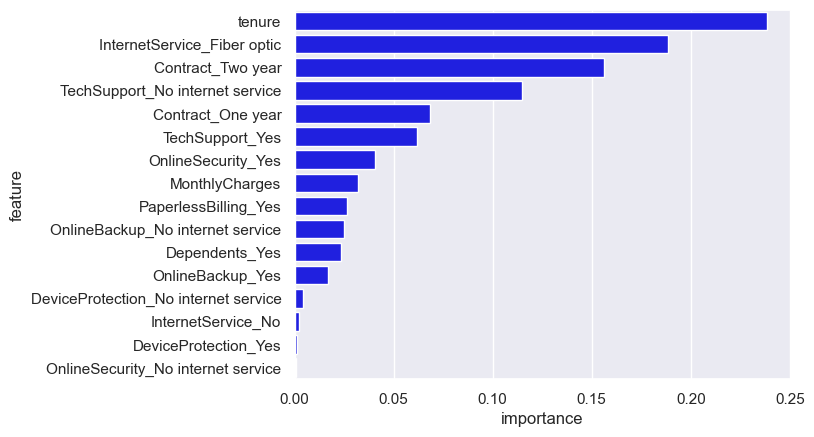

In [ ]:
sns.barplot(data=imp, y='feature', x='importance', color='b');

Berdasarkan feature importance dari model Gradient Boosting, fitur yang paling berpengaruh terhadap churn adalah:
- Tenure
- Contract
- InternetService

In [ ]:
ct = pd.crosstab(df['OnlineSecurity'], df['Churn'])
ct

Churn,0,1
OnlineSecurity,,
No,1419,1001
No internet service,928,75
Yes,1218,212


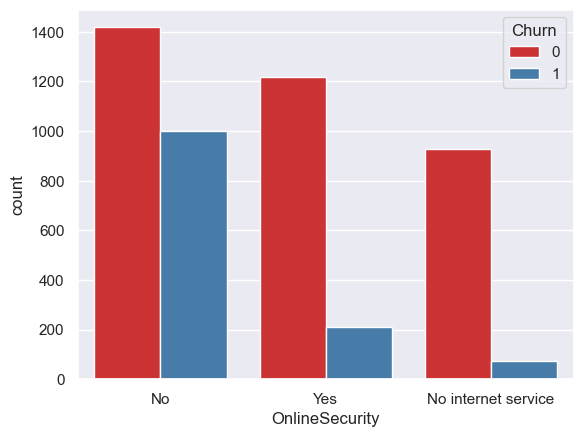

In [ ]:
sns.countplot(data=df, x='OnlineSecurity', hue='Churn');

In [ ]:
df['tenure'].unique()

array([ 9, 14, 64, 72,  3, 40, 17, 11,  8, 47, 18,  5,  1, 48, 13, 58,  7,
        4, 70, 34, 31, 37, 15, 71, 10, 43, 22, 33, 69, 54, 63, 55, 66, 56,
       32, 26, 24,  2, 51, 23, 49, 28, 36, 45, 42,  6, 61, 59, 67, 65,  0,
       16, 52, 41, 25, 62, 20, 50, 30, 60, 19, 35, 57, 27, 44, 53, 12, 46,
       39, 29, 38, 68, 21], dtype=int64)

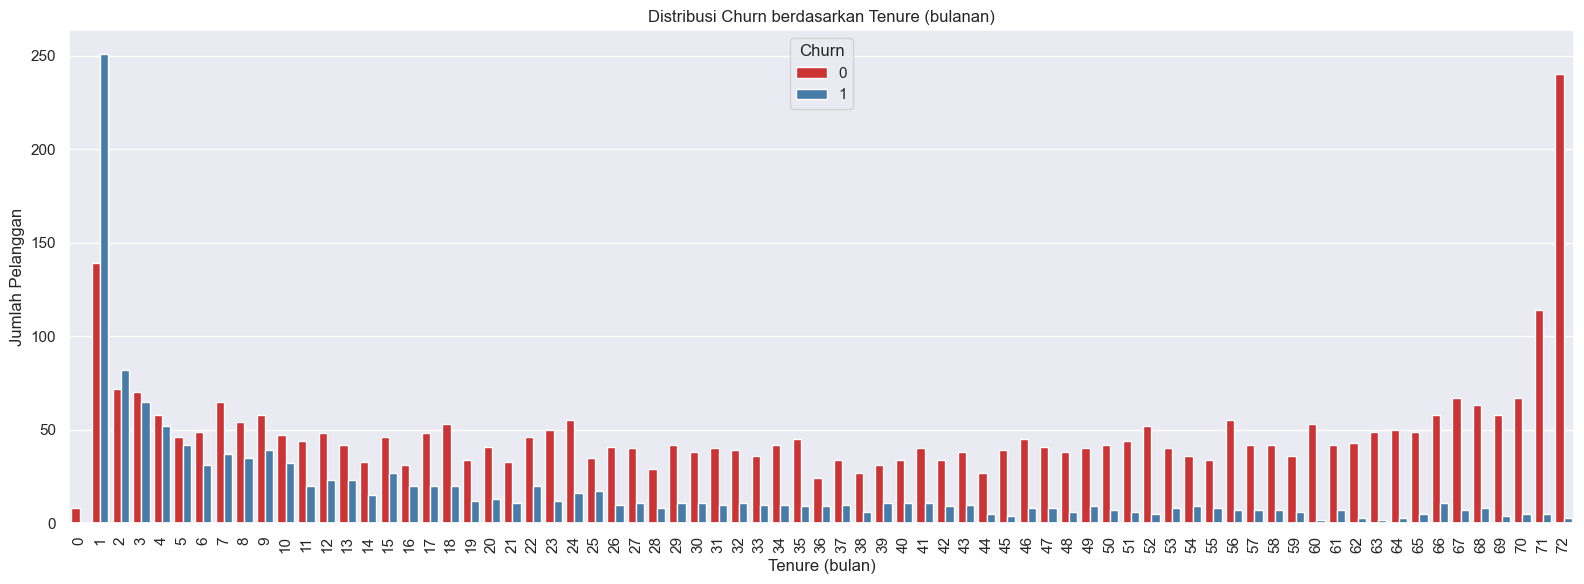

In [ ]:
plt.figure(figsize=(16,6))
sns.countplot(data=df, x='tenure', hue='Churn')
plt.xticks(rotation=90)
plt.title('Distribusi Churn berdasarkan Tenure (bulanan)')
plt.xlabel('Tenure (bulan)')
plt.ylabel('Jumlah Pelanggan')
plt.tight_layout()
plt.show()


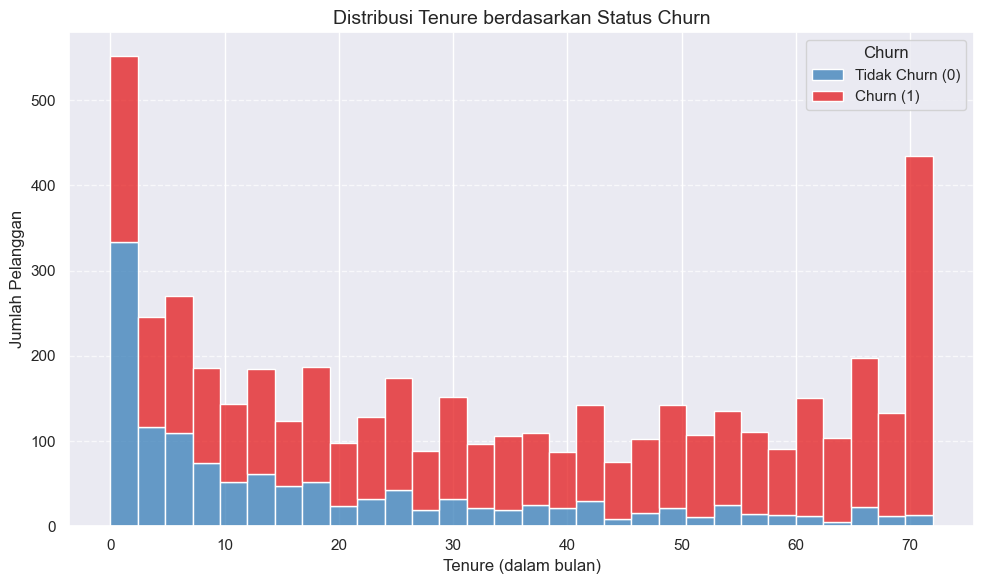

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30)

plt.title('Distribusi Tenure berdasarkan Status Churn', fontsize=14)
plt.xlabel('Tenure (dalam bulan)', fontsize=12)
plt.ylabel('Jumlah Pelanggan', fontsize=12)
plt.legend(title='Churn', labels=['Tidak Churn (0)', 'Churn (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 14. Summary untuk Analisis Data selanjutnya

- Tenure (Lama Berlangganan) — Importance: 0.238
    - Pelanggan dengan masa langganan pendek (terutama <6 bulan) memiliki risiko churn yang tinggi.
    - Visualisasi menunjukkan lonjakan churn pada bulan ke-1.

- InternetService_Fiber optic — Importance: 0.189
    - Pelanggan dengan layanan fiber optic lebih cenderung churn dibanding DSL atau tidak ada layanan internet.

- Contract_Two year dan Contract_One year — Importance: 0.156 & 0.068
    - Pelanggan dengan kontrak jangka panjang cenderung lebih loyal.

- TechSupport_No internet service / Yes — Importance: 0.115 & 0.062
    - Tersedianya layanan dukungan teknis berkorelasi negatif dengan churn.

- Terlihat lonjakan churn di awal masa langganan (1-3 bulan), khususnya di bulan pertama.
- Churn hampir tidak terjadi setelah bulan ke-60.

- Pelanggan jangka pendek (< 20 bulan) mendominasi churn.
- Pelanggan jangka panjang (> 60 bulan) didominasi oleh yang tidak churn (loyal customer).

Feature yang bisa dihapus:
1. OnlineBackup
    - Berdasarkan feature importance sebelumnya, kontribusi OnlineBackup terhadap prediksi churn sangat rendah. Meskipun layanan ini bisa menjadi indikator churn, ternyata dalam data ini tidak terlalu informatif.

2. DeviceProtection
    - Sama seperti OnlineBackup, fitur ini juga memiliki importance sangat kecil dan tampaknya tidak memberikan diferensiasi signifikan antara churn dan non-churn.

# Kesimpulan dan Rekomendasi

## 15. Kesimpulan

1. Tingkat Churn Pelanggan
   
    Dari total data, sekitar 26,6% pelanggan melakukan churn. Ini menunjukkan bahwa lebih dari seperempat pelanggan memilih berhenti menggunakan layanan, yang merupakan sinyal kuat bagi manajemen untuk meningkatkan retensi pelanggan.

2. Pengaruh Fitur terhadap Churn

    Berdasarkan feature importance dari model Gradient Boosting, fitur yang paling berpengaruh terhadap churn adalah:
    - tenure
    - MonthlyCharges
    - Contract
    - InternetService

3. Evaluasi Model Gradient Boosting
    - F2 Score (Test Set) sebelum tuning: 0.71
    - F2 Score (Test Set) sesudah tuning: 0.755

    Artinya, tuning hyperparameter berhasil meningkatkan performa model dalam mengenali pelanggan yang benar-benar akan churn. Metrik F2 Score dipilih karena False Negative (kehilangan pelanggan) memiliki dampak biaya ($500) yang jauh lebih besar dibanding False Positive ($100).

4. Efisiensi Biaya Promosi
    - Tanpa ML, promosi diberikan ke seluruh pelanggan, menyebabkan biaya sia-sia sebesar $71,300.
    - Dengan ML, promosi menjadi lebih tepat sasaran dan kerugian turun menjadi $39,300.
    - Machine Learning berhasil menurunkan kerugian sampai 45% dari total kerugian sebelumnya

## 16. Rekomendasi

Rekomendasi

1. Implementasikan Model Gradient Boosting ke Proses Operasional
    
    Gunakan model ini dalam sistem pemasaran untuk memprioritaskan pelanggan berisiko tinggi churn agar mendapat perhatian khusus (diskon, insentif, komunikasi aktif).

2. Fokus pada Fitur Penting Pertimbangkan Penghapusan Fitur Kurang Relevan
    
    Perusahaan dapat memusatkan analisis dan strategi pada pelanggan dengan:
    - Kontrak bulanan
    - Tenure pendek
    - Biaya bulanan tinggi
    - Jenis layanan internet tertentu (misalnya DSL atau Fiber)

3. Kembangkan Strategi Customer Retention

    Berdasarkan hasil model, rancang strategi berbasis data untuk mengurangi churn, seperti:
    - Penawaran kontrak tahunan
    - Program loyalitas untuk pengguna baru
    - Paket bundling layanan internet dan telepon

4. Monitoring & Evaluasi Berkala

    Model perlu dipantau dan ditingkatkan secara berkala untuk menyesuaikan dengan tren dan perilaku pelanggan yang dinamis.

## 17. Save Final Model

In [64]:
# best model
gbc_tuning = random_gbc.best_estimator_
gbc_tuning

# fitting
gbc_tuning.fit(X,y)

# save dengan pickle
pickle.dump(gbc_tuning, open('model_gbc.sav','wb'))

In [65]:
# load model

model_loaded = pickle.load(open('model_gbc.sav', 'rb'))
model_loaded 

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['tenure', 'MonthlyCharges']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract',
                                                   'PaperlessBilling'])])),
                ('resampler', RandomUnderSampler(random_state=42)),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.2, max_depth=1,
                                            max_features=5, n_estimators=234,
                                            random_state=0, subsample=0.3))])

In [66]:
# y actual = 1 --> churn
y[0]

1

In [35]:
# customer index 0 akan diprediksi
df.iloc[[0], :]

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.9,1


In [39]:
# customer index 4 akan diprediksi
df.iloc[[3], :]

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,0
